
# **Introduction:**

Le hasard est l'élément déclencheur d'un évènement dont aucune cause connue n'explique la réalisation. La notion de hasard s'oppose donc au déterminisme, source de nombreux débats scientifiques et philosophiques.

Le premier objectif de notre projet est de générer numériquement une suite « aléatoire » de nombres, c'est à dire une suite de nombres "tirés au hasard". La définition formelle (mathématique) d'une suite aléatoire est encore débattue de nos jours et l'existence même de telles suites ne fait pas l'unanimité. Par exemple, Emile Borel émet un paradoxe sur la définition du hasard mathématique : le fait de définir une suite aléatoire comme une suite n’ayant aucune propriété particulière revient à donner à cette suite une propriété (celle de ne pas en avoir) la rendant non aléatoire. Nous ne prétendons donc pas générer des suites de nombres parfaitement aléatoires. Notre but est de générer des suites de nombres dont la structure est très difficilement identifiable et ne possédant aucune régularité, on parle de suites de nombres *pseudo-aléatoires*. Dans un second temps, nous utilisons ces suites de nombres *pseudo-aléatoires* pour simuler des lois de variables aléatoires usuelles. Enfin, nous utilisons ces simulations pour calculer des valeurs numériques approchées, par exemple d’intégrales ou de $\pi$, avec des méthodes probabilistes, les méthodes de Monte Carlo. Nous comparons notamment ces méthodes probabilistes à des méthodes numériques itératives de calcul intégral comme la méthode des rectangles.  
<br />





Nous avons choisi de travailler sur ce sujet suite à la lecture d'un article sur le site de M. Dupré nommé *Simulation d’une loi statistique avec un algorithme d’optimisation $A^{*}$*. Nous nous sommes alors rendu compte que nous avions utilisé de nombreuses fois sur Python des fonctions de génération de lois de probabilités (avec les libraires *scipy* ou *numpy* par exemple) sans même savoir sur quoi reposaient ces fonctions. Nous étions curieux et voulions en apprendre plus sur ces méthodes de génération, étant donné que nous serons amenés à réutiliser de nombreuses fois ces fonctions au cours de notre scolarité à l'ENSAE. Ainsi, nous avons décidé de travailler sur les algorithmes de génération de lois de probabilités et sur les méthodes de Monte Carlo.


### Import des librairies

In [ ]:
from matplotlib.pyplot import *
import math as mat
import numpy as np
from numpy import polynomial
from numpy.random import *
from scipy.misc import *
from scipy.stats import kstest
from scipy.special import factorial
from scipy import optimize
from scipy import stats

# **$\rm I)$ Générateurs pseudo-aléatoires**


Un générateur pseudo-aléatoire est un algorithme qui à partir d'un certain nombre (la graine) et d'un entier $n$, génère une suite de nombres de longueur $n$ vérifiant certaines propriétés statistiques rendant sa structure difficilement identifiable. La suite produite est déterministe puisqu'elle est générée par un algorithme : à longueur et graine fixées, l'algorithme génèrera toujours la même suite de nombres. On parle donc de *générateurs pseudo-aléatoires*.

La qualité d'une suite pseudo-aléatoire dépend de ses propriétés statistiques, on évalue donc cette suite avec des théorèmes et des outils statistiques comme par exemple la loi de grands nombres ou les tests d'adéquation.

Dans cette première partie, nous allons générer de nombres pseudo-aléatoires entre 0 et 1. Les générateurs uniformes nous permettent de construire ensuite tous les générateurs de loi de probabilités usuelles. Nous allons illustrer à l'aide de différents générateurs pseudo-aléatoires les biais et limites empêchant la génération d'une suite parfaitement aléatoire. 

Les algorithmes de géneration que nous avons implémenté ont une même structure:

*   ils nécessitent un nombre initial nommé la graine.
*   les nombres qui suivent sont définis par une relation de récurrence,  $ x_{k+1} = f(x_{k})$.


## a) Méthodes d'évaluation d'un algorithme

Pour évaluer un algorithme, nous utilisons certaines propriètés statistiques de la loi uniforme sur $[0;1]$. La première est la loi des grands nombres, la moyenne empirique doit tendre vers $\frac{1}{2}$. Ensuite, la fonction de répartiton empirique doit être "proche" de la fonction de répartition théorique: c'est le test de Kolmogorov Smirnov. Enfin, la liste des nombres générés ne doit pas  comporter de périodes, c'est à dire une certaine succesion de nombres qui se répèteraient. Pour détecter les périodes/cycles, nous  utilisons l'algorithme de Floyd (aussi nommé algorithme du lièvre et de la tortue).

**Loi forte des grands nombres**

In [ ]:
def LGN(X):
  return(abs(np.mean(X)-0.5))

**Test de Kolmogorov Smirnov**

Nous implémentons le test de Kolmogorov Smirnov qui est un test statistique permettant de tester si un échantillon suit une certaine loi de probabilité $\mathbb{P}$. Ce test est valable si la fonction de répartition $F_{ref}$ associée à $P$ est continue. Ce test va servir dans un premier temps à vérifier que notre suite de nombres pseudo-aléatoires suit bien une loi uniforme sur $[0;1]$. Nous l'utiliserons également ensuite dans la partie $II)$ pour vérifier nos simulations de variables aléatoires.

Ce test repose sur deux théorèmes, le théorème de Glivenko Cantelli et le théorème de Kolmorov. Soit $(X_{n})_{n}$ une suite de variables aléatoires *iid* de f.d.r. $F$ ($F$ est inconnue et on cherche à déterminer si $F=F_{ref}$. On note $F_{n}$ la fonction de répartition empirique, le théorème de Glivenko Cantelli nous assure que $D_{n} :=||F_{n} -F||_{∞}$ converge presque sûrement vers $0$. $F_{n}$ est donc un estimateur satisfaisant de $F$. De plus, le théorème de Kolmogorov assure que si $F$ est continue alors la loi de $D_{n}$ ne depend pas de $F$. Ce résultat  est très pratique puisqu'il rend la variable $D_{n}$ universelle, un test basé sur $D_{n}$ sera valable pour n'importe quelle variable aléatoire dont la fonction de  répartition est continue. La loi $D_{n}$ est tabulée, on note $d_{n,\alpha}$ son quantile d'ordre $\alpha$. Le test de Kolmogorov Smirnov de niveau $\alpha$, sous l'hypothèse nulle $F=F_{ref}$, est :


$\phi:=1_{D_{n}>d_{n,1-\alpha}}$ avec cette fois ci $D_{n} :=||F_{n} -F_{ref}||_{∞}$, $F$ étant inconnue.  
  




  Le calcul pratique de $D_{n}$ est facilité par la formule suivante:
$D_n = \max_{1 \leq i \leq n} \max \left\{ \frac{i}{n} - F(X_{(i)}), \, F(X_{(i)}) - \frac{i-1}{n}\right\}.$ où les $(X_{(i)})_{i}$ sont supposés ordonnés.

In [ ]:
#on définit une fonction qui permet de calculer Dn:
def Dn(X,Fref):
    n = len(X)
    Y = np.sort(X) #on trie puisque la formule nécessite une  suite ordonnée
    return max([max(i/float(n)-Fref(Y[i-1]),Fref(Y[i-1])-(i-1)/float(n)) for i in range(1,n+1)]) #formule pratique

#test de Kolmogorov

#les quantiles sont tabulés, on importe la table des quantiles avec scipy.stats:
from scipy.stats import ksone

def dn_value(alpha,n):
    return ksone.ppf(1-alpha, n) #quantile d'ordre 1-alpha pour un certain n


def test_kolmo(X,Fref,alpha):
    if Dn(X,Fref)>dn_value(alpha,len(X)):
      return "l'échantillon ne suit pas la loi de réfèrence"
    return "l'échantillon suit la loi de réfèrence"

On illustre graphiquement le test de Kolmogorov Smirnov en testant un générateur aléatoire que nous étudierons plus loin, la fonction *numpy.random.rand( )*. La condition $D_{n} > d_{n,1-\alpha}$ se réecrit $F(x)-d_{n,1-\alpha}<F_{n}(x) < F(x) + d_{n,1-\alpha}$ pour tout $x \in \mathbb{R}$.

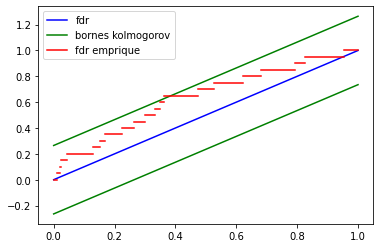

test de kolmogorov smirnov: l'échantillon ne suit pas la loi de réfèrence


In [ ]:
n = 20
d = dn_value(0.05,n)

#fdr
xx = np.linspace(0,1,101)
plot(xx,xx,'b')

#borne sup de kolmogorov
plot(xx,xx+d,'g')
 

#on trace la fonction de répartition empirique
U = rand(n)
X = np.sort(U)
plot([0,X[0]],[0,0],'r-')
for i in range(1,n):
    plot([X[i-1],X[i]],[i/float(n),i/float(n)],'r-') 
plot([X[-1],1],[1,1],'r-')

#pour bien légender on trace ensuite la borne inf de kolmogorov
plot(xx,xx-d,'g')

legend(["fdr", "bornes kolmogorov","fdr emprique"])
show()

#si la fdr empirique  est bien entre les deux droites vertes on peut affirmer que F=Fref.
print("test de kolmogorov smirnov:",test_kolmo(U, lambda x:x,0.05))

**Algorithme de Floyd**  

L'algorithme de Floyd (ou du lièvre et de la tortue) permet de détecter des cycles dans une liste de nombres $(x_{k})_{k}$. Cet algorithme repose sur le fait que si la liste admet un cycle, il existe un indice $j$ tel que $x_{j} = x_{2j}$. On parcourt donc la liste à deux vitesses, la tortue à une vitesse $1$ et le lièvre à une vitesse $2$. Ainsi le lièvre va commencer par parcourir $x_{2},x_{4}, x_{6}, x_{8}$ alors que la tortue parcourira $x_{1}, x_{2}, x_{3}, x_{4}$. Comparer le lièvre et la tortue nous permet de comparer les couples $(x_{k},x_{2k})$ et donc de trouver le cycle.

In [ ]:
def floyd(f,x0): 
  m=0
  tortue = f(x0)
  lievre = f(tortue)
  #on cherche un cycle, ie on cherche xj = x2j
  while tortue!=lievre and m<10**4: #on ajoute un nombre max d'itérations, 10**4, pour pas que l'algo tourne indéfiniment si il n'y as pas de cycles
    m+=1
    tortue = f(tortue) #vitesse 1
    lievre = f(f(lievre)) #vitesse 2

  if m == 10**4: 
    return "pas de cycle trouvé"
  return "présence d'un cycle"


## a) Premier génerateur historique: l'algortihme de Von Neuman.

Cet algorithme est aussi nommé algorithme des carrés médians. Soit un nombre entier initial $x_{0}$ à $n$ chiffres (la graine). On définit par récurrence $x_{k+1}$ comme les $n$ chiffres médians de $x_{k}^2$. Par exemple si $x_{0}=1111, x_{0}^{2}=1234321$ et donc $x_{1} = 3432$. Il faut qu'à chaque itération $x_{k}$ soit de longueur $2n$, si ce n'est pas le cas on ajoute des $0$ à la fin de $x_{k}$.

In [ ]:
#on définit la relation de récurrence entre x_k+1 et x_k

def f_VNeuman(x):

  n = len(x)
  x = str(int(x)**2)
  t = str(x)

  while len(t)<2*n:
    t = t + "0"
  res = t[2:6]
  return res


In [ ]:
def Von_Neuman(x0,n): #x0 = nombre initial , n = longueur de la suite de nombre pseudo aléatoire souhaitée.
  X = [x0]
  for i in range(n):
    X.append(f_VNeuman(X[-1]))
  Y =  list(map(int, X))
  return Y


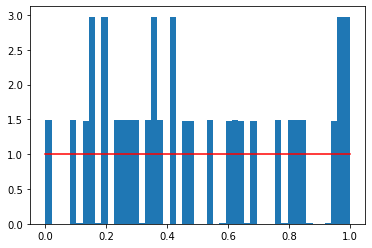

In [ ]:
Y = Von_Neuman("1783",10**4)
R = [i/max(Y) for i in Y] #pour avoir des nombres entre 0 et 1
hist(R, bins=np.linspace(0,1,50), density=True);
plot([0,1],[1,1],'r') #densité théorique
show()


Etant donné l'histogramme, on peut supposer que cet algorithme comporte un cycle. Nous allons évaluer cet algorithme avec nos trois méthodes, on vérifiera notamment la présence d'un cycle.

In [ ]:
print(LGN(R)) #l'algorithme passe le test de la loi des grands nombres
print(floyd(f_VNeuman,"1783")) #il y a un cycle
test_kolmo(R, lambda x:x,0.05)

0.001509585216009024
présence d'un cycle


"l'échantillon ne suit pas la loi de réfèrence"

## c) Les génerateurs à congruence linéaire mixte

Les génerateurs à congruence linéaire mixte sont des générateurs définis via une relation de récurrence du type $x_{k+1} = ax_{k} + b \space \space  mod[m]$; $\space \space x_{0}$ désigne la graine. Des théorèmes d'arithmétique donnent des formules pour $a,b,m$ et $x_{0}$ assurant  une bonne qualité pour le générateur. En particulier, ces générateurs sont cycliques et certains paramètres permettent d'obtenir un cycle très long. Nous admettons ces théorèmes et utilisons directement certains paramètres efficients. Par exemple, l'algorithme de Parker Miller utilise $x_{0} = 3, a = 69069, b= 0$  et $m = 2^{32}$.

In [ ]:
def f_pmiller(x):
  return (69069*x)%2**32

def parker_miller(n):
  X =[3]
  for i in range(n):
    X.append(f_pmiller(X[-1]))

  return X

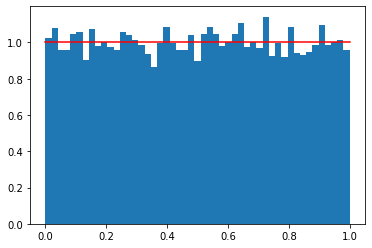

In [ ]:
X = parker_miller(10**4)
Y = [i/max(X) for i in X] #pour ramener sur l'intervalle [0;1]
hist(Y, bins=np.linspace(0,1,50), density=True);
plot([0,1],[1,1],'r') #densité théorique
show() 

In [ ]:
#on évalue l'algorithme:
print(LGN(Y)) #l'algorithme passe le test de la loi des grands nombres
print(floyd(f_pmiller,3)) #il y a un cycle, mais de longueur supérieure à 10**4, notre algorithme ne le trouve pas
test_kolmo(Y, lambda x:x,0.05)

0.0005399374236823573
pas de cycle trouvé


"l'échantillon suit la loi de réfèrence"

## d) L'algorithme de Mersenne Twister et la fonction $rand()$ de Numpy.random.

Cet algorithme fait partie de la famille des générateurs à congruence linéaire mixte. C'est un algorithme particulièrement performant, sa période est de $2^{19937}-1$ (le nombre de Mersenne à la puissance $199937$) et il est plus rapide que la plupart des générateurs. La fonction $rand()$ de Numpy.random génère une suite de nombres entre 0 et 1 avec l'algorithme de Mersenne Twister. Le choix de la graine au moment de l'éxecution se fait à partir du nombre de microsecondes de l'horloge de l'ordinateur. Ceci permet d'avoir de l'aléa dans le choix de la graine et ainsi, en lançant à deux instants différents la fonction, on obtient deux suites de nombres entre 0 et 1 indépendantes, donc deux variables aléatoires uniformes indépendantes.

In [ ]:
rand()

0.7693020583220664

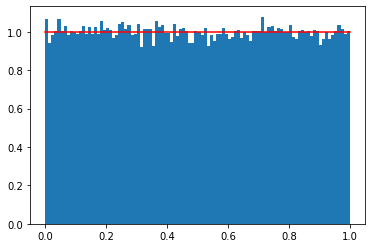

0.0014488396605510379
pas de cycle trouvé


"l'échantillon suit la loi de réfèrence"

In [ ]:
n=10**5
X=rand(n)
hist(X, bins = np.linspace(0,1,101), density = True) #densité empirique
plot([0,1],[1,1],'r') #densité théorique
show()

print(LGN(X))
print(floyd(f_pmiller,3)) #il y a un cycle, mais de longueur supérieure à 10**4, notre algorithme ne le trouve pas
test_kolmo(Y, lambda x:x,0.05)

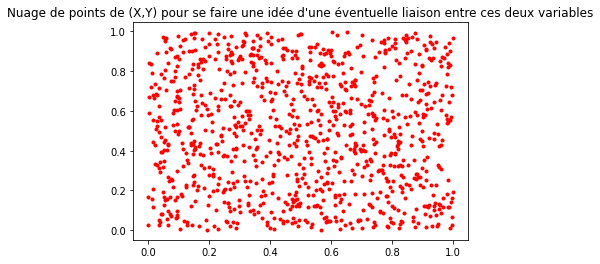


Conclusion:
etant donnée la p-value, on peut affirmer que les variables sont independantes


In [ ]:
#simulation de deux lois uniformes independantes

U = rand(10**3)
V = rand(10**3)

#indépendance
plot(U,V,'r.') #les variables semblent indépendantes étant donné le  nuage de points
title("Nuage de points de (X,Y) pour se faire une idée d'une éventuelle liaison entre ces deux variables")
show()

#test d'indépendance, H0 : les variables sont indépendantes
print()
print("Conclusion:")
if stats.spearmanr(U, V).pvalue > 0.05:
  print("etant donnée la p-value, on peut affirmer que les variables sont independantes")
else:
  print("etant donnée la p-value, nous rejetons l'hypothèse d'independance des variables")

# **$\rm II)$  Simulation de variables aléatoires**

A présent, nous allons simuler numériquement des variables aléatoires usuelles à partir des générateurs pseudo-aléatoires. Plusieurs méthodes démontrées mathématiquement nous garantissent que toutes les variables aléatoires réelles ou discrètes (à valeurs dans $\mathbb{N}$ ) peuvent être générées à partir d'une loi uniforme, d'où l'intérêt de la génération de nombres pseudo-aléatoires entre $0$ et $1$. 

Le meilleur générateur (en temps de calculs et en qualité de génération) parmi ceux étudiés dans la première partie est celui donné par la fonction *numpy.random.rand()* (basé sur l'algorithme de Mersenne Twister). Nous allons donc utiliser ce générateur pour simuler une loi uniforme sur $[0;1]$. De plus, cet algorithme permet d'obtenir lois uniformes indépendantes, ceci est très utile pour la génération de certaines lois comme la loi gaussienne avec la méthode de Box Muller.


## a) Méthode d'inversion de la fonction de répartition

Soit $\mathbb{P}$ une probabilité sur $\mathbb{R}$ et $F$ la fonction de répartition associée. Pour tout $t \in ]0;1[$ on définit $F^{-}(t):= \inf \left\{ x \in \mathbb{R}, F(x)\geq t \right\}$ \\


**Théorème:** 
soit $U$ une variable aléatoire uniforme sur $[0;1]$, alors $F^{-}(U)$ suit la loi $\mathbb{P}$.

Ce résultat nous permet donc de simuler n'importe quelle variable aléatoire réelle (ou discrète puisque $\mathbb{N} \subset \mathbb{R}$) à partir d'une loi uniforme. Cependant, le calcul de $F^{-}$ peut s'avérer particulièrement compliqué. $F^{-}$ est facilement calculable si $F$ est strictement croissante car dans ce cas $F$ est inversible et $F^{-}$ coïncide avec $F^{-1}$. $F^{-}$ est également facile à calculer si la loi est discrète.

**Simulation de la loi exponentielle de paramètre $\lambda > 0$:**

La fonction de répartition d'une loi exponentielle est strictement croissante, on a donc une formule explicite pour $F^{-}$ donnée par $ x \rightarrow -\frac{log(1-x)}{\lambda} $


In [ ]:
def simu_expo(l, n): # l=lambda ,  n = nombre de simulations
    U = rand(n)
    #on retourne F-(U)
    return -(1/l)*np.log(U) # 1-U et U suivent la même loi donc on peut simplement mettre U

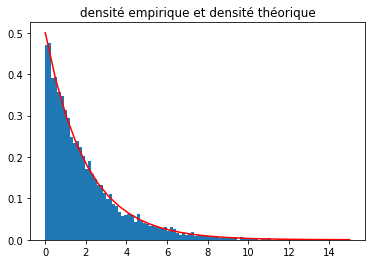

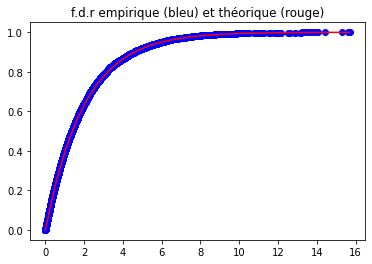

"l'échantillon suit la loi de réfèrence"

In [ ]:
#simulation

n=10**4
xx=np.linspace(0,15,30)
X = simu_expo(0.5,n) #exponentielle de paramètre 1/2
hist(X, bins = np.linspace(0,15,101), density = True); #densité empirique
plot(xx,0.5*np.exp(-0.5*xx) ,'r'); #densité théorique
title("densité empirique et densité théorique")
show()


#fonction de répartition::
X = sorted(X) #renvoie une liste triée, nécessaire pour tracer la fonction de répartition empirique
xx = np.linspace(0,max(X),30)
plot(X,np.linspace(0,1,n),'bo') #fonction de répartition empirique
plot(xx,1-np.exp(-xx/2),'r') # fonction de réparition théorique
title("f.d.r empirique (bleu) et théorique (rouge)")
show()

#test de kolmogorov pour tester notre simulation:
test_kolmo(X,lambda x:1-np.exp(-0.5*x), 0.05) 


**Simulation de la loi de Cauchy de paramètres $a> 0$ et $x_{0} \in \mathbb{R}$:**

Comme pour la loi exponentielle la fonction de répartition est strictement croissante, on a donc une formule explicite pour $F^{-}$, $F^{-}: x \rightarrow a \times tan(\Pi(x-0.5)) +x_{0} $


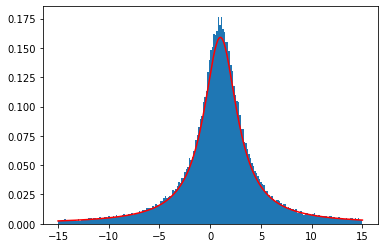

In [ ]:
def simulation_cauchy(n,a,x0): #n = nombre de simulations
    U= rand(n)
    X = x0 + a*np.tan(np.pi*(U-1/2)); #F-(U)
    return(X)

n=10**5
Y = simulation_cauchy(n,2,1) #a=2, x0= 1
xx = np.linspace(-15,15,201)
hist(Y, bins=xx,density=True); #densité empirique
plot(xx,1/(np.pi*2*(1+((xx-1)/2)**2)),'r') #densité théorique
show()


<br />

Dans le **cas discret**, $F^{-}$ est aussi facile à calculer puisque la fontion de répartion $F$ est constante par morceaux et continue à droite, $F = \sum_{i}  q_{i} \mathbb{1}_{[x_{i},x_{i+1}[}$  avec $q_{i} = \sum_{\mathbb{1} \leq j \leq i} p_{j} $. Les valeurs prises par $F^{-}$ sont donc $ \left\{x_{i}, i \in I\right\}$ avec $I$ dénombrable. Par exemple, voyons comment simuler une loi de Bernoulli.
  


**Simulation d'une loi de Bernoulli de paramètre $p \in ]0;1[$:**

Pour une Bernoulli de paramètre $p$, on a:

Pour tout $t \leq p $, $F^{-}(t) = 0$ et pour tout $t \geq p $, $F^{-}(t) = 1$.

In [ ]:
def simu_bernoulli(p,n):
  U = rand(n)
  X = 1*(U<p)
  return X

0.7065


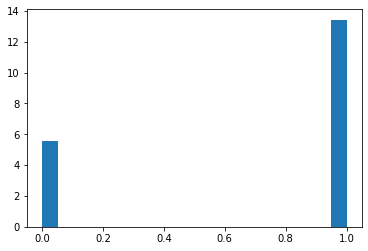

In [ ]:
#simulation
X = simu_bernoulli(0.7,10**4) # p = 0.7
hist(X, bins = np.linspace(0,1,20), density = True); 
print(np.mean(X)) #on vérifie que l'espérance est bien de 0.7

**Simulation d'une loi de Poisson de paramètre $\lambda >0$:**

Dans un premier temps, nous allons calculer $F$ puis déduire $F^{-}$ à partir de $F$. Comme une loi de Poisson donne une masse strictement positive à tout $n$ entier naturel, nous ne pouvons pas contruire $F$ complètement. Cependant, l'inégalité de Markov nous assure que $\mathbb{P}(X>10\lambda) < 1/10$. La probabilité d'être dix fois supérieure à $\lambda$ est inférieure à 0.1, nous choississons donc de ne construire $F$ que sur $\left\{0,...,10\lambda \right\}$.

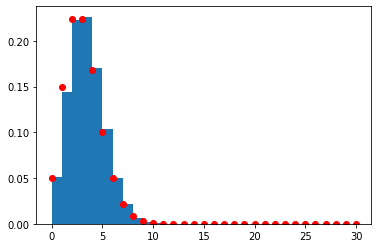

In [ ]:
def simu_poisson(l, n):
  X = np.zeros(n)

  #on construit F sur {0,..,10*lambda}
  s = 10*l
  #on commence par construire la fonction de masse en attribuant sa masse à chaque entier naturel inférieur à 10*lambda
  T = np.zeros(s) 
  for i in range(s):
    T[i] = (np.exp(-l) * l**i)/factorial(i)

  #on obtient F avec la somme cumulée de la fonction de masse
  C = np.cumsum(T)
  np.append(C,1) #on ajoute 1 puisqu'une fonction de réparition doit tendre vers 1 en l'infini.

  #on déduit F- de F (par définition de F-) et on l'applique à une uniforme (rand())
  for i in range(n):
    X[i] = np.where(rand() < C)[0][0]
  return X

l=3
X = simu_poisson(l,10**4)
xx = np.linspace(0,10*l,10*l+1)
hist(X, bins=xx, density = True); #fonction de masse empirique
plot(xx, (np.exp(-l)*l**xx)/factorial(xx), 'ro') #fonction de masse théorique

**Simulation d'une loi binomiale de paramètre $p \in ]0;1[$ et $m \in \mathbb{N}$:**

On utilise le fait qu'une loi binomiale de paramètre $(m,p)$ est égale en distribution à la somme de $m$ variables de Bernoulli de paramètre $p$ indépendantes. La fonction $rand()$ nous permet de générer des variables uniformes indépendantes,  nous pouvons donc également générer des variables de Bernoulli indépendantes.

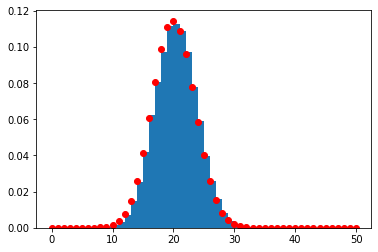

In [ ]:
def simu_binomiale(m,p,n):
  M = np.zeros((m,n))

  for i in range(m):
    M[i,:] = simu_bernoulli(p,n)

  return np.sum(M,axis=0) #on somme les Bernoulli indépendantes  pour obtenir des Binomiales

m = 50
p = 0.4
n = 10**5

X = simu_binomiale(m,p,n)
xx = np.linspace(0,m,m+1)
hist(X, bins=xx, density=True);#fonction de masse empirique
plot(xx, factorial(m)/(factorial(xx)*factorial(m-xx))*p**xx*(1-p)**(m-xx),'ro'); #fonction de masse théorique



## b) Méthode du rejet

La méthode du rejet permet de simuler des lois admettant une densité par rapport à la mesure de Lebesgue. Cette méthode nécessite également de disposer d'une loi auxiliaire admettant aussi une densité par rapport à la mesure de Lebesgue et qui vérifie certaines propriètés vis à vis de notre loi d'intérêt.
L'idée est qu'on sait simuler facilement la loi auxiliaire et on se sert de cette loi pour simuler notre loi d'intérêt.  

Formellement, supposons qu'on souhaite générer une variable $X$ de loi $\mathbb{P}$ admettant une densité $f$ par rapport à la mesure de Lebesgue et que l'on dispose d'une variable $Y$ de loi $\mathbb{Q}$ aussi continue par rapport à la mesure de Lebesgue, de densite $g$ telle que $\frac{f}{g}$ soit bornée par une constante $c$  ($*$). On pose $ \rho = \frac{f}{g}$. Soient $(U_{k})_{k}$ une suite de variables i.i.d. uniformes  sur $[0;1]$ et $(V_{k})_{k}$ une suite de variables i.i.d. de loi $\mathbb{Q}$. <br />
Alors, $K:= \inf \left\{ k \geq 1, U_{k} \leq \frac{\rho(V_{k})}{c} \right\}$ suit une loi géométrique de paramètre $\frac{1}{c}$ et $V_{K}$ suit la loi $\mathbb{P}$ (la loi que l'on souhaite simuler).


In [ ]:
def simu_rejet(p,simu,n): 
  X = np.zeros(n)
  c = -optimize.fmin(lambda x: -p(x), 0, full_output=True)[1]; 

  for i in range(n):
    U = 2
    Y = 0

    while U > p(Y)/c: 
        U = rand();
        Y = simu(1);
    X[i] = Y

  return X

**Simulation d'une loi gaussienne à partir d'une loi de Cauchy avec la méthode du rejet:**

Nous savons simulé une loi de Cauchy grâce à la méthode d'inversion de la fonction de répartiton. La méthode d'inversion de la fonction de répartition est difficilement applicable à une loi gaussienne puisque l'on ne dispose pas de formule explicite pour la fonction de répartition d'une gaussienne. Toutefois, la loi gaussienne et la la loi de Cauchy admettent une densité par rapport à la mesure de Lebesgue et ces densités verifient la propriété $(*)$. On peut donc simuler une variable gaussienne à l'aide d'une variable de loi de Cauchy:


Optimization terminated successfully.
         Current function value: -1.520347
         Iterations: 25
         Function evaluations: 50


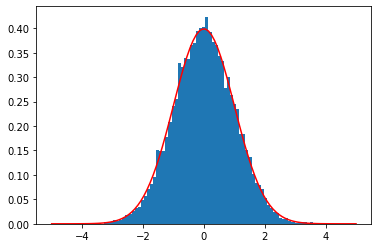

"l'échantillon suit la loi de réfèrence"

In [ ]:
def p(x): # p = f/g, le rapport des densités
  return ((1/np.sqrt(2*np.pi))*np.exp(-0.5*(x)**2)) / (1/(np.pi*(1+x**2))) #rapport des densités

def simu_gaussienne(n): #la fonction de simulation de la loi auxiliaire, ici une loi de Cauchy(a=1,xo=0)
  return simulation_cauchy(n,1,0)

xx = np.linspace(-5,5,100)
X = simu_rejet(p,simu_gaussienne,10**4)
hist(X,bins=xx,density=True) #densité empirique
plot(xx,(1/np.sqrt(2*np.pi))*np.exp(-0.5*(xx)**2),'r') #densité théorique
show()

#test, on utilise scipy car on a pas de formule explicite pour la fdr d'une loi normale
from scipy.stats import norm
test_kolmo(X,lambda x:norm.cdf(x), 0.05)

L'algorithme de rejet implémenté ne possède pas un nombre maximal d'itérations. Si l'on note $N$ le nombre d'itérations, $N$ suit une loi géométrique de paramètre $\frac{1}{c}$ car la probabilité de rejeter $V_{k}$ vaut $c$. Il faut donc choisir $c$ le plus petit possible pour avoir le moins d'itérations et donc un algorithme performant. Il faut donc chercher une loi auxiliaire dont la densité $g$ est "proche" de $f$.

Nous illustrons ceci en calculant le nombre d'itérations pour générer une loi gaussienne avec la méthode du rejet en utilisant deux densité auxilaires différentes.

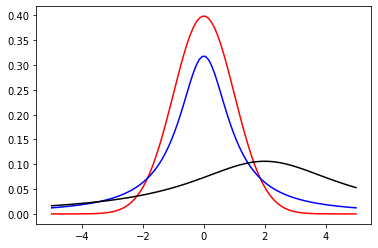

In [ ]:
xx = np.linspace(-5,5,100)
plot(xx,(1/np.sqrt(2*np.pi))*np.exp(-0.5*(xx)**2),'r') #gaussienne centrée réduite
plot(xx,1/(np.pi*(1+xx**2)),'b') #Cauchy(a=1,x0=0)
plot(xx,1/(3*np.pi*(1+((xx-2)/3)**2)),'k') #Cauchy(a=3,x0=2)

La densité de la loi Cauchy(a=3,x0=2) (en noir) est beaucoup plus "éloignée" de la densité de la loi gaussienne (en rouge) que la densité de la loi Cauchy(a=1,x0=0) (en bleu). Ceci fait que la probabilité de rejet sera plus élevée avec la Cauchy(a=3,x0=2) et la méthode de rejet nécessitera plus d'itérations. Nous le vérifions en comptant les itérations de l'algorithme de rejet avec ces deux lois auxiliaires: 

In [ ]:
#même fonction mais qui renvoie en plus le nombre d'itérations

def simu_rejet_iter(p,simu,n):
  cpt= 0 # compteur du nombre d'itérations
  X = np.zeros(n)
  c = -optimize.fmin(lambda x: -p(x), 0, full_output=True)[1];
  print(c)

  for i in range(n):
    U = 2
    Y = 0

    while U > p(Y)/c:
        cpt+=1
        U = rand();
        Y = simu(1);
    X[i] = Y;

  return X,cpt

Optimization terminated successfully.
         Current function value: -1.520347
         Iterations: 25
         Function evaluations: 50
1.5203469010662807
Optimization terminated successfully.
         Current function value: -5.708680
         Iterations: 22
         Function evaluations: 44
5.708680136706425


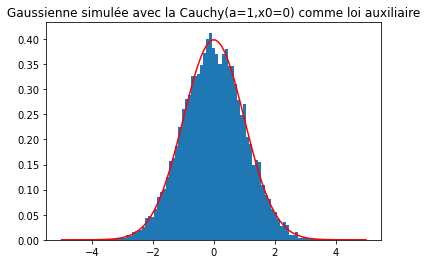

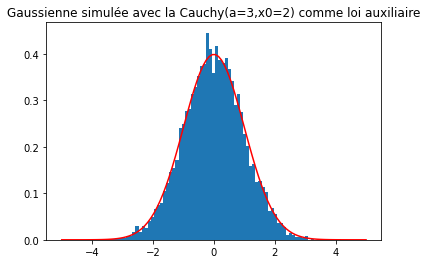

nombre d'itérations Cauchy(a=1,x0=0):  15261
nombre d'itérations Cauchy(a=3,x0=2):  57691


In [ ]:
#avec la Cauchy(a=1,x0=0)
def p(x):
  return ((1/np.sqrt(2*np.pi))*np.exp(-0.5*(x)**2)) / (1/(np.pi*(1+x**2)))
def simu_gaussienne(n):
  return simulation_cauchy(1,1,0)

#avec la Cauchy(a=3,x0=2)
def p2(x):
  return ((1/np.sqrt(2*np.pi))*np.exp(-0.5*(x)**2)) / (1/(3*np.pi*(1+((x-2)/3)**2)))
def simu_gaussienne2(n):
  return simulation_cauchy(1,3,2)


X, c1 = simu_rejet_iter(p,simu_gaussienne,10**4)
Y , c2 = simu_rejet_iter(p2,simu_gaussienne2,10**4)

hist(X,bins=xx,density=True)
plot(xx,(1/np.sqrt(2*np.pi))*np.exp(-0.5*(xx)**2),'r')
title("Gaussienne simulée avec la Cauchy(a=1,x0=0) comme loi auxiliaire")
show()

hist(Y,bins=xx,density=True)
plot(xx,(1/np.sqrt(2*np.pi))*np.exp(-0.5*(xx)**2),'r')
title("Gaussienne simulée avec la Cauchy(a=3,x0=2) comme loi auxiliaire")
show()

print("nombre d'itérations Cauchy(a=1,x0=0): ",c1)
print("nombre d'itérations Cauchy(a=3,x0=2): ",c2)



Dans les deux cas, nous parvenons à simuler une loi gaussienne centrée réduite, la loi de Cauchy(a=3,x0=2) engendre beaucoup plus d'itérations comme la constante $c$ associée est plus grande.

**Simulation d'une loi Bêta à partir d'une loi uniforme avec la méthode du rejet:**

Comme dans le cas précèdent, la loi Bêta et la loi uniforme (toutes deux ayant comme support $[0;1]$) vérifient la proprièté $(*)$, on peut donc utiliser l'algorithme de rejet pour simuler une loi Bêta à partir d'une loi uniforme.

  
La loi Bêta de paramètres $a,b \in \mathbb{R}^{+*}$ admet comme densité $f: x → \frac{\gamma(a+b)}{\gamma(a)\gamma(b)}x^{a-1}(1-x)^{b-1}\mathbb{1}_{[0;1]}(x)$ .

Optimization terminated successfully.
         Current function value: -2.109375
         Iterations: 24
         Function evaluations: 48


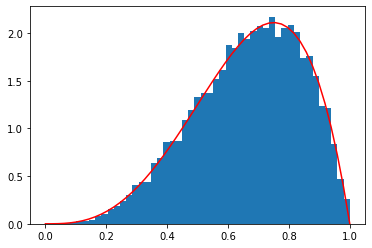

In [ ]:
a , b = 4 , 2

def p_bis(x): # p = rapport des densités (comme précedemment)
  return (mat.gamma(a+b)/(mat.gamma(a)*mat.gamma(b)))*x**(a-1)*(1-x)**(b-1)

def simu_beta(n): #simulation de la loi auxiliaire: la loi uniforme
  return rand(n)

xx = np.linspace(0,1,50)
X = simu_rejet(p_bis,simu_beta,10**4)
hist(X,bins=xx,density=True) #densité empirique
plot(xx,(mat.gamma(a+b)/(mat.gamma(a)*mat.gamma(b)))*xx**(a-1)*(1-xx)**(b-1),'r') #densité théorique

## c) Méthodes par changement de variables

Enfin, nous implémentons quelques méthodes de simulation basées sur des changements de variables. Supposons que l'on veuille simuler une variable aléatoire de loi $\mathbb{P}$ et que l'on sache simuler une variable aléatoire $X$. L'idée est de trouver un changement de variable adéquat $\phi$ tel que $\phi(X)$ suit la loi $\mathbb{P}$. Biensûr, de tels changements de variables ne sont pas toujours possibles; nous allons impleménté quelques changements de variables connus. L'avantage de ces méthodes est que chaque variable suivant la loi auxilaire est utilisée contrairement à la méthode du rejet où seulement une partie des variables est utilisée dans la géneration. Les changements de variables sont donc moins coûteux en termes d'itérations.

**Le changement de variable de Box Muller**

Soient $(U_{k})_{k}$ et  $(V_{k})_{k}$ deux suites de variables iid indépendantes de lois uniformes sur $[0;1]$. Alors, les variables $X_{k}:=\sqrt{-2\log(U_{k})}cos(2\Pi V_{k})$ et $V_{k}:=\sqrt{-2\log(U_{k})}sin(2\Pi V_{k})$ sont indépendantes et suivent une loi normale centrée réduite.

In [ ]:
def Box_Muller(n):
  U = rand(n)
  V = rand(n)
  X = np.sqrt(-2*np.log(U))*np.cos(2*np.pi*V)
  Y = np.sqrt(-2*np.log(U))*np.sin(2*np.pi*V)
  return X,Y


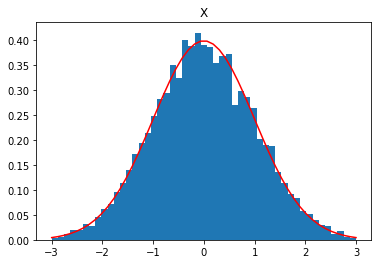

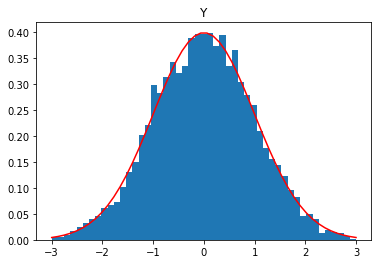

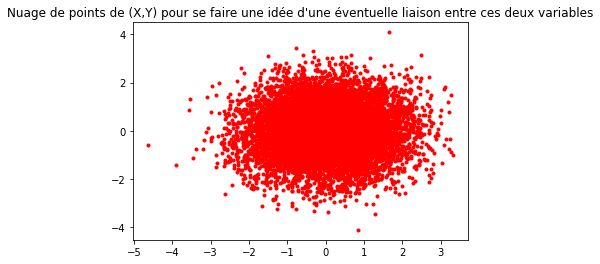


Conclusion:
etant donnée la p-value, on peut affirmer que les variables sont independantes


In [ ]:
n = 10**4
X,Y = Box_Muller(n)

xx = np.linspace(-3,3,50)
hist(X,bins=xx,density=True)
plot(xx,(1/np.sqrt(2*np.pi))*np.exp(-0.5*(xx)**2),'r')
title("X")
show()

hist(Y,bins=xx,density=True)
plot(xx,(1/np.sqrt(2*np.pi))*np.exp(-0.5*(xx)**2),'r')
title("Y")
show()

#indépendance
plot(X,Y,'r.') #les variables semblent indépendantes étant donné le  nuage de points
title("Nuage de points de (X,Y) pour se faire une idée d'une éventuelle liaison entre ces deux variables")
show()
#test d'indépendance, H0 : les variables sont indépendantes
print()
print("Conclusion:")
if stats.spearmanr(X, Y).pvalue > 0.05:
  print("etant donnée la p-value, on peut affirmer que les variables sont independantes")
else:
  print("etant donnée la p-value, nous rejetons l'hypothèse d'independance des variables")

**Changement de variable pour la loi Bêta**  

Si $U$ suit une loi uniforme sur $[0;1]$, $sin^{2}(\Pi \frac{U}{2})$ suit la loi Bêta de paramètres 1/2 et 1/2.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in power
  # Remove the CWD from sys.path while we load stuff.


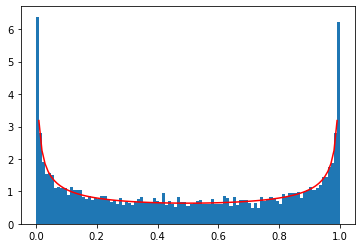

In [ ]:
def ch_var_beta(n):
  U = rand(n)
  return np.sin(np.pi*0.5*U)**2

a , b = 0.5, 0.5

xx = np.linspace(0,1,100)
X = ch_var_beta(10**4)
hist(X,bins=xx,density=True)
plot(xx,(mat.gamma(a+b)/(mat.gamma(a)*mat.gamma(b)))*xx**(a-1)*(1-xx)**(b-1),'r')

## d) Simulation de lois Gaussiennes avec le Théorème Central Limite (TCL)

Soit $(U_{k})_{k}$ une suite de variables aléatoires iid admettant un moment d'ordre 2. Notons $m$ leur espérance et $\sigma$  leur variance, le Théorème Central Limite nous assure que $\frac{\sqrt{n}}{\sigma} \times (\frac{1}{n}\sum_{i=1}^n U_{i} -m)$ converge en loi vers une variable normale centrée réduite lorsque $n \rightarrow +\infty$ .

Prenons pour $(U_{k})_{k}$ une suite iid de variables uniformes sur $[0;1]$ (on aurait pu choisir n'importe quelle loi admettant un moment d'ordre 2):

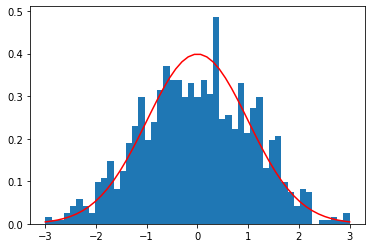

In [ ]:
n = 10**4 #nombre de simulations de variables gaussiennes
k = 10**3 #nombre d'uniformes pour générer chaque gaussienne, on considère être dans l'asymptotique à 10**3.


U = np.zeros((k,n))
for i in range(k):
  U[i,:] = rand(n)

X = 12*np.sqrt(k)*(np.mean(U,axis=1)-0.5) #on applique la formule du TCL aux n vecteurs de taille k contenant des uniformes iid.
xx = np.linspace(-3,3,50)
hist(X,bins=xx,density=True)
plot(xx,(1/np.sqrt(2*np.pi))*np.exp(-0.5*(xx)**2),'r')

# **$\rm III)$ Applications : les méthodes de Monte Carlo**

L'aléatoire joue un rôle important dans le calcul intégral numérique, à travers les méthodes de Monte Carlo.



D'abord, nous montrons une illustration classique de Monte Carlo afin de trouver la valeur de $\pi$ (en intégrant l'indicatrice du disque unité sur $[-1,1]^2$). Ensuite, nous verrons l'implémentation de la méthode de Monte Carlo sur python pour les fonctions à support unidimensionnel et comparerons ses résultats avec ceux des méthodes numériques classiques déterministes de calculs d'intégrales. Finalement, nous généraliserons en dimension $d$ afin d'illustrer le *fléau de la dimension*.

##  a) Introduction avec le calcul approché de $\pi$

L'aire du disque de rayon $1$ est $\pi$ et l'aire d'un carré de coté de longueur $2$ centré en $(0,0)$ est $4$. Si l'on simule une loi uniforme sur ce carré, la probabilité $p$ de se trouver dans le disque est le rapport entre les deux aires soit  $\frac{\pi}{4}$. Ainsi $\pi = 4p$. Cette formule nous donne une méthode pour obtenir une valeur approchée de $\pi$ :

*   A l'aide deux variables uniformes indépendates sur $[-1;1]$, on génère une loi uniforme sur $[-1;1]^{2}$.
*   On approxime $p$ en calculant le rapport entre le nombre de réalisations dans le disque unité et le nombre total de réalisations.
* Une fois $p$ approximée, on approxime $\pi = 4p$ .




In [ ]:
U = rand(10**6)
V = rand(10**6)
pi_approx = 4*len(U[U**2 + V**2<1])/10**6
print("approximation: ",pi_approx, "//  vraie valeur: ",np.pi)    

approximation:  3.139184 //  vraie valeur:  3.141592653589793


##  b) Calcul intégral numérique en dimension 1



### Monte Carlo sur un segment de $\mathbb{R}$



Soit $f$ une fonction d'une variable réelle à valeurs réelles, intégrable sur $\mathbb{R}$. On souhaite calculer $I(f) : = \int_{\mathbb{R}} f$.   

Soit $X$ une variable aléatoire réelle de loi $\mathbb{P}_{X}$ et $g$ une fonction d'une variable réelle à valeurs réelles telle que $E[|g(X)|]$ existe. Le théorème de transfert nous permet d'affirmer que $E[g(X)] = \int_{\mathbb{R}} g(x) d\mathbb{P}_{X}(x)$. De plus, si $X$ admet une densité $f_{X}$ par rapport à la mesure de Lebesgue, $E[g(X)] = \int_{\mathbb{R}} g(x) \times f_{X}(x) dx $.  
   
Le principe de la méthode de Monte Carlo est de trouver une variable aléatoire $X$ et une fonction $g$ (avec $E[|g(X)|] < +∞$)  telles  que $E[g(X)] = I(f)$.

Etant donné que $E[|g(X)|] < +∞$, la loi forte des Grands nombres s'applique: soient $(X_{k})_{k}$ une suite  de variables *iid* de loi $\mathbb{P}_{X}$, $\frac{1}{n}\sum_{i}^{n} g(X_{i})$ converge presque sûrement vers $E[g(X)]=I(f)$. On a donc un estimateur convergeant et sans biais de $I(f).$

  
De plus, il est possible de construire un intervalle de confiance asymptotique de $I(f)$ avec le Théorème Central Limite:  
$ \mathbb{P}(I(f) \in [G_{n} - c\sqrt{\frac{Var(g(X))}{n}} ; G_{n} + c\sqrt{\frac{Var(g(X)}{n}} ])$ $→$ $\int_{[-c;c]}\frac{e^{-\frac{x^{2}}{2}}}{\sqrt{2\Pi}}dx$.  
Pour $c=2.6$ , $\int_{[-c;c]}\frac{e^{-\frac{x^{2}}{2}}}{\sqrt{2\Pi}}dx >0.99$. Il est donc possible d'obtenir un encadrement très précis avec une probabilité élevée de $I(f)$ pour $n$ grand. Cependant, ceci nécessite de connaître $Var(g(X))$, on l'estime à l'aide de : $\sigma_{n}^{2} := \frac{1}{n} \sum_{i}^{n}g(X_{i})^{2} - G_{n}^{2}$ .  
  
Finalement, $\mathbb{P}(|G_{n} - I(f)|< c\frac{\sqrt{\sigma_{n}^{2}}}{\sqrt{n}})$ $→$ $\int_{[-c;c]}\frac{e^{-\frac{x^{2}}{2}}}{\sqrt{2\Pi}}dx$. En d'autres termes, notons $e_{n}$ l'erreur, $e_{n} := |G_{n} - I(f)|$; avec une probabilité $1-\alpha$,  $|e_{n}|<q_{1-\frac{\alpha}{2}}\frac{\sqrt{\sigma_{n}^{2}}}{\sqrt{n}}$ où $q_{1-\frac{\alpha}{2}}$ désigne le quantile d'ordre $1-\alpha$ de la loi normale centrée réduite.


Nous commençons par définir une fonction *MC1* qui permet d'approximer avec la méthode de Monte Carlo $\int_{[a;b]} f(x) dx$. En effet, dans le cas où $f$ est à support compact $[a,b]$, en prenant $X$ une variable aléatoire de loi uniforme sur $[a;b]$ et $g=(b-a)f$ on a $I(f)= E[g(X)]$. Il est donc toujours possible d'approximer $I(f)$ avec les méthodes de Monte Carlo lorsque f est à support compact. 

In [ ]:
def MC1(f,a,b,n):
  U = (b-a)*rand(n)+a #loi uniforme sur [a;b]
  Y = f(U)

  return sum(Y)*(b-a)/n #formule de MC donnée par la loi des grands nombres

In [ ]:
#on approxime l'intégrale sur [0.3] de x-->x**2, la valeur théorique est 9.

def f(x):
  return x**2

MC1(f,0,3,10**5)

9.021761428604282

Nous allons à présent illuster numériquement les propriètés asymptotiques de la méthode de Monte Carlo. Dans un premier temps, nous calculons la probabilité asymptotique que l'intervalle de confiance $[G_{n} - c\sqrt{\frac{Var(g(X))}{n}} ; G_{n} + c\sqrt{\frac{Var(g(X)}{n}} ]$ contienne $I(f)$. Cette probabilité doit être proche de $\int_{[-c;c]}\frac{e^{-\frac{x^{2}}{2}}}{\sqrt{2\Pi}}dx$.

Nous considérons que $10^{4}$ est asymptotique est nous prenons $c=1.645$, le quantile d'odre $0.05$ de la loi normale centré réduite. En théorie, nous devons obtenir une probabilité proche de $0.9= 1-2\times 0.05.$

In [ ]:
def intervalle_TCL(n,f, I, a,b,c): # I = I(f), n = nombre d'approximations calculées

  cpt = 0 #on compte le nombre de fois où I(f) est effectivement dans l'intervalle de confiance (IC)
  approx = [] #liste des valeurs approximées
  bsup = [] #liste des bornes sup des intervalles de confiance
  binf =[] #liste des bornes inf des intervalles de confiance

  for i in range(n):
    Gn = MC1(f,a,b,10**4)
    sigma_n = MC1(lambda x:f(x)**2,a,b,10**4) #on estime par MC1 sigma2
    approx.append(Gn)
    bsup.append(Gn + c*np.sqrt(sigma_n/10**4))
    binf.append(Gn - c*np.sqrt(sigma_n/10**4))
    if I < Gn + c*np.sqrt(sigma_n/10**4) and I > Gn - c*np.sqrt(sigma_n/10**4):
      cpt+=1
  return approx,cpt/n, bsup, binf #on retourne les valeurs d'aproximation, la proba d'être dans un IC et les valeurs des IC.

def f(x):
  return x**2

resultats = intervalle_TCL(10**3,f,9,0,3,1.96)
#on a pris le quantile d'ordre 0.05, la probabilité théorique est donc 1-2*0.05 = 0.9
print("Probabilité théorique = 0.9", "probabilité empirique:" ,resultats[1])

Probabilité théorique = 0.9 probabilité empirique: 0.906


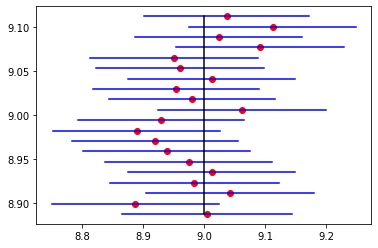

In [ ]:
#Répresentaion graphique des Intervalles de confiances (IC)

#on calcul 20 valeurs approchées et 20 IC. On a toujours alpha = 0.05
resultats = intervalle_TCL(20,f,9,0,3,1.96)

val = resultats[0] #valeurs d'approximation fournies par Monte Carlo
xx = np.linspace(min(val), max(val), len(val)) #les valeurs obtenues sont en abscisse
plot(val,xx,'ro')

#bornes des IC:
bsup = resultats[2]
binf = resultats[3]
#autour de chaque valeur approchée, on trace l'intervalle de confiance associé
for i in range(len(binf)):
  plot((binf[i],bsup[i]), (xx[i],xx[i]),'b-')

#vraie valeur : 9, on voit ainsi si un intervalle de confiance contient ou non la vraie valeur.
plot((9,9), (xx[0], xx[-1]), 'k-')

### Monte Carlo sur $\mathbb{R}_+$

La loi uniforme n'est définie que sur des ensembles bornés. Si l'on souhaite intégrer une fonction sur un ensemble non borné il faut utiliser une loi ayant comme support cet ensemble. Par exemple, sur $\mathbb{R}_{+}$, on peut utiliser une loi exponentielle, on nomme cette loi la loi auxiliaire. Notons $g$ la densité de la loi auxiliaire, $f$ doit s'annuler partout où $g$ s'annule. Si cette conditon est vérifiée on a $I(f) : = \int_{\mathbb{R}} \frac{f(x)}{g(x)}g(x) dx$. On pose $\Psi = \frac{f}{g}, I(f) = E[\Psi(X)]$, cette formule nous permet d'approximer $I(f)$ via Monte Carlo. Etant donné que l'intervalle de confiance dépend de $Var(\Psi(X))$, il faut prendre $g$ "proche" de $f$ pour minimiser cette variance.

Approximons $I = \int_{0}^{\infty} e^{-x^2/2} dx.$ à l'aide d'une variable exponentielle. On sait que $I\cong 1.2533$

In [ ]:
def MC1_Rplus(f,n):
  return np.mean(f(simu_expo(1,n))) #estimateur de Monte Carlo


MC1_Rplus(lambda x : np.exp(-0.5*x**2)/np.exp(-x),10**4)

1.250549169996661

In [ ]:
#Un test unitaire
import unittest

class Tests(unittest.TestCase):
  
    def test_MC_Rplus(self):
        '''teste la méthode de Monte Carlo sur support unidimensionnel infini '''
        res = MC1_Rplus(lambda x : np.exp(-x),10000)
        self.assertLessEqual(res,1.01)



In [ ]:
unittest.main(argv=[''], verbosity=2, exit=False)

test_MC_Rplus (__main__.Tests)
teste la méthode de Monte Carlo sur support unidimensionnel infini ... ok

----------------------------------------------------------------------
Ran 1 test in 0.007s

OK


### Une méthode numérique usuelle : la méthode des trapèzes

Nous allons comparer la méthode de Monte Carlo à des méthodes numériques déterministes. Nous commençons la comparaison avec la méthode des trapèzes.

In [ ]:
def methode_trapezes(f,debut,fin,n):
  x = np.linspace(debut,fin,n)
  y = f(x)
  aire_trapezes = (y[:-1]+y[1:])/2 * (fin-debut)/n
  
  return sum(aire_trapezes)

### Comparaison des méthodes en dimension 1 sur un calcul intégral

Nous choisissons de comparer nos deux méthodes (Monte Carlo et trapèzes) sur le calcul intégral de $x\rightarrow e^x$ sur $[-1,1]$. Pour Monte Carlo, nous ne faisons qu'un seul lancer ici, cela illustre la variance de cette méthode. Le résultat théorique est $2\sinh(1)$.

Text(0.5, 1.0, 'Représentation des erreurs en fonction de la puissance de 10 de nombres de points utilisés(en dimension d = 2)')

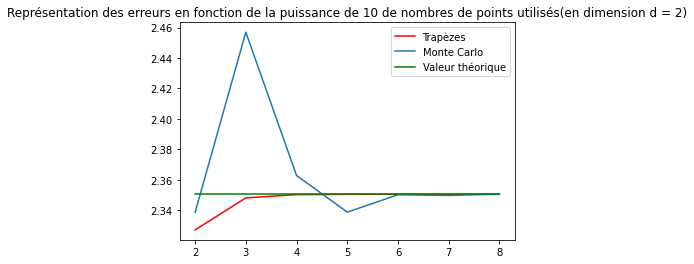

In [ ]:
debut = -1
fin = 1

N = 9
I_rect = []
I_MC = []
Puissance = []

for i in range(2,N):
  Puissance.append(i)
  I_rect.append(methode_trapezes(lambda x : np.exp(x),debut,fin,10**i))
  I_MC.append(MC1(lambda x : np.exp(x),debut,fin,10**i))

figure()
plot(Puissance,I_rect,"red")
plot(Puissance,I_MC)
plot([2,N-1],[2*np.sinh(1),2*np.sinh(1)],"green")
legend(["Trapèzes","Monte Carlo","Valeur théorique"])

title("Représentation des erreurs en fonction de la puissance de 10 de nombres de points utilisés(en dimension d = 2)")

**Conclusion en dimension 1** : les méthodes numériques usuelles sont assez efficaces par rapport à la méthode de Monte Carlo.

C'est pourquoi nous nous intéressons dans la partie suivante au calcul intégral pour des fonctions définies sur des espaces de dimension supérieure.


## c) Calcul intégral numérique en dimension d

### **Monte Carlo** en dimension *d*

In [ ]:
 # n le nombre de points tirés au hasard ; #support est un tableau de dimension d x 2, ou sur la ligne i, on a le début et la fin du support selon l'axe i

In [ ]:
#calcul de l'hypersurface du support

In [ ]:
def MC(f,support,n):
  d = len(support) #dimension de l'espace
  X = np.empty((d,n)) #array pour l'échantillon de points du support de f

  for i in range(d):
    X[i] = (support[i][1] - support[i][0])*rand(n) + support[i][0]
  X = X.T

  Y = np.apply_along_axis(f,1,X)

  V = np.exp(sum(np.log(support[:,1]-support[:,0]))) #hypersurface du support

  return sum(Y)*V/n

In [ ]:
support = np.array([[-1,1],[-1,1]])

d = 2
n = 10

X = (support[0][1]-support[0][0])*rand(d,n) + support[0][0]

print(X)

[[-0.38675815 -0.01167437 -0.18425774 -0.58715789  0.87184745 -0.81445785
  -0.68881883  0.75874879  0.71790907 -0.8769566 ]
 [ 0.24848916  0.05122871  0.03930476 -0.50395067 -0.69817611 -0.91555843
   0.958194   -0.86112393  0.97744139  0.10529602]]


### **Méthodes des rectangles** en dimension *d*



Nous avons en dimension 1 utilisé la méthode des trapèzes. Pour généraliser en dimension d, nous utilisons la méthode des rectangles, facilement transposable en dimension d :
- Nous découpons l'hypercube en $n$ petits hypercubes.
- Nous évaluons pour chaque hypercube sa valeur en son sommet dont chaque coordonnée est la plus petite valeur atteinte dans l'hypercube.
- Nous approximons finalement l'intégrale de la fonction sur l'hypercube principal par la **valeur moyenne** de la fonction sur ses hypercubes, multiplié par le **volume** de l'hypercube.

In [ ]:
def methode_rectangle_d(fonc,support,n):
  d = len(support)
  n_par_axe = int(n**(1/d))

  # Création du array X, dont chaque élément et un point de R^d où la fonction f est à évaluer
  X = np.linspace(support[0][0],support[0][1],n_par_axe)
  for i in range(1,d): #réalisation du produit cartésien
   X = np.meshgrid(X,np.linspace(support[i][0],support[i][1],n_par_axe))
  X = np.array(X).reshape(2,-1).T

  # Calculs finaux pour la méthode des rectangles
  Y = np.apply_along_axis(fonc,1,X)
  V = np.exp(sum(np.log(support[:,1]-support[:,0])))

  return sum(Y)*V/n_par_axe**d

### **Comparaison des méthodes** en dimension *d*

Il s'agit de comparer les deux méthodes pour le calcul de la fonction $x \in \mathbb{R}^d\rightarrow (\sum_{i=1}^d x_i)^2$.

In [ ]:
def carre_somme(vecteur):
  return (sum(vecteur))**2

Pour cette comparaison, notre support est $[-1,1]^d$.

#### Calcul théorique

On note ce qu'on veut calculer $I_d = \int_{[-1,1]^d}(\sum_{i=1}^d x_i)^2dx_1...dx_d$.

Or $(\sum_{i=1}^d x_i)^2 = \sum_{i=1}^d x_i  +2\sum_{i<j} x_ix_j$.

Le terme de droite est impair en $x_i$ et on intègre sur un intervalle symétrique par rapport à 0, donc l'intervalle de ce terme est nulle.

Donc $I_d = \int_{[-1,1]^d}\sum_{i=1}^d (x_i)^2dx_1...dx_d = \sum_{i=1}^d \int_{[-1,1]^d}(x_i)^2dx_1...dx_d$.

On a pu intervertir somme et intégrale, car c'est une somme finie.

Soit $i\in [1,d]$.

On veut intégrer le i-ème terme de la somme. Le théorème de Fubini donne qu'on peut intégrer dans l'ordre des variables qu'on veut.

On intègre d'abord par rapport à $dx_i$ :
$$\int_{[-1,1]}x_i^2dx_i=\frac{2}{3}$$

D'où : $$\int_{[-1,1]^d}(x_i)^2dx_1...dx_d = \frac{2^d}{3}$$

Donc : $$\boxed{I_d=d*\frac{2^d}{3}}$$.


In [ ]:
def calcul_theorique_carre_somme(d):
  return d*2**d/3

In [ ]:
def support_d(d):
  return np.array([[-1,1]]*d)

#### Complexité des algorithmes : en O(n)

In [ ]:
def temps_res(methode,fonc,support,n): #fonction qui renvoie le temps d'exécuation et le résultat 
                        #d'une méthode pour une fonction, un support et un nombre de points donnés.
  t0 = time.time()
  res = methode(fonc,support,n)
  t1 = time.time()

  t = t1 - t0

  return (t,res)

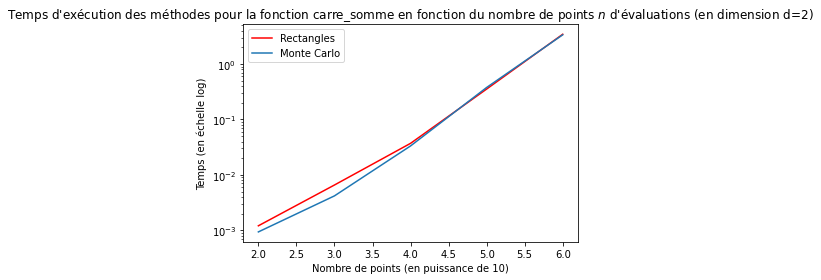

In [ ]:
N = 7

support = support_d(2)
X = []
Y_rect = []
Y_MC = []
for i in range(2,N):
  X.append(i)
  Y_rect.append(temps_res(methode_rectangle_d,carre_somme,support,10**i)[0])
  Y_MC.append(temps_res(MC,carre_somme,support,10**i)[0])


plot(X,Y_rect,"red")
plot(X,Y_MC)
legend(["Rectangles","Monte Carlo"])
title("Temps d'exécution des méthodes pour la fonction carre_somme en fonction du nombre de points $n$ d'évaluations (en dimension d=2)")
xlabel("Nombre de points (en puissance de 10)")
ylabel("Temps (en échelle log)")
yscale("log")

*Remarque* : nous aurions préféré passer l'échelle des abscisses en échelle linéaire, mais nous n'avons pas trouvé de solution. C'est pourquoi, pour contourner ce problème, nous avons mis l'échelle du temps en ordonnées en échelle log.

**Conclusion.** On en déduit que les deux méthodes ont des complexités linéaires du nombre de points. (Nous pouvons penser à la méthode de Gauss Legendre qui n'est pas du tout linéaire en le nombre de points évalués, car dans cette méthode il s'agit de calculer dans un premier temps les racines d'une certain famille de polynômes orthogonaux).

Ici, pour comparer nos fonctions, il s'agit donc surtout de comparer leurs résultats en termes d'erreur.

#### Erreurs des méthodes

Text(0, 0.5, "Valeur calculée de l'intégrale")

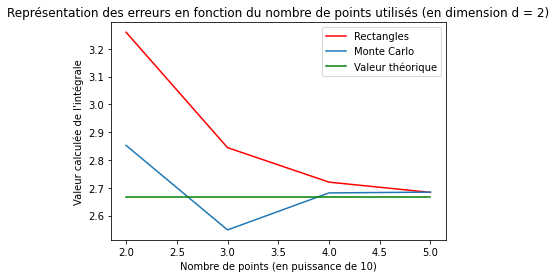

In [ ]:
d = 2
support = support_d(d)
I_rect = []
I_MC = []
Puissance = []

for i in range(2,6):
  Puissance.append(i)
  I_rect.append(methode_rectangle_d(carre_somme,support,10**i))
  I_MC.append(MC(carre_somme,support,10**i))

figure()
plot(Puissance,I_rect,"red")
plot(Puissance,I_MC)
plot([2,5],[calcul_theorique_carre_somme(d),calcul_theorique_carre_somme(d)],"green")
legend(["Rectangles","Monte Carlo","Valeur théorique"])
title("Représentation des erreurs en fonction du nombre de points utilisés (en dimension d = 2)")
xlabel("Nombre de points (en puissance de 10)")
ylabel("Valeur calculée de l'intégrale")



#### Complexité en dimension

Text(0.5, 1.0, "Représentation du temps d'exécution des méthodes en fonction de la dimension d de l'espace sur lequel on intègre carre_somme")

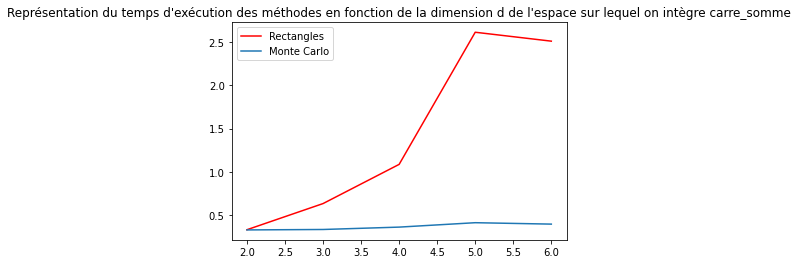

In [ ]:
D = 7

X = []
Y_rect = []
Y_MC = []
for i in range(2,D):
  X.append(i)
  Y_rect.append(temps_res(methode_rectangle_d,carre_somme,support_d(i),100000)[0])
  Y_MC.append(temps_res(MC,carre_somme,support_d(i),100000)[0])


plot(X,Y_rect,"red")
plot(X,Y_MC)
legend(["Rectangles","Monte Carlo"])

title("Représentation du temps d'exécution des méthodes en fonction de la dimension d de l'espace sur lequel on intègre carre_somme")

La méthode des rectangles semble perdre d'autant plus d'efficacité que la dimension augmente.

#### Théorème d'invariance de l'erreur en fonction du nombre de points pour Monte Carlo

Par ailleurs, un théorème donne que la méthode de Monte Carlo a besoin d'un nombre constant de points pour avoir une erreur absolue maximale fixée, **indépendamment de la dimension dans laquelle on se trouve.**

C'est ce que nous illustrons avec le graphique suivant.

In [ ]:
def n_pour_erreurfixe(methode,epsilon,d) : #renvoie le nombre de points nécessaires pour une erreur absolue inférieure à epsilon 
  n = 100
  support = support_d(d)
  erreur = 100

  while erreur>epsilon:
    n *= 10
    erreur = abs(calcul_theorique_carre_somme(d) - MC(carre_somme,support,n))

  return n

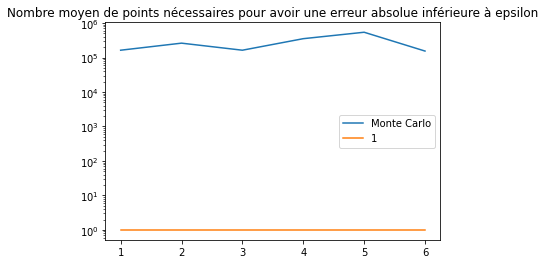

In [ ]:
#Représentation graphique

D = 7
epsilon = 10**-2
N = 10 #nombre d'échantillons pour la Monte Carlo

X = []
Y_rect = []
Y_MC = []

for i in range(1,D): #on fait croître la dimension
  X.append(i)
  Y_MC_echantillon = np.empty(N)
  
  for j in range(N):
    Y_MC_echantillon[j] = n_pour_erreurfixe(MC,epsilon,d)
  
  Y_MC.append(np.mean(Y_MC_echantillon))


plot(X,Y_MC)
plot([1,D-1],[1,1])
legend(["Monte Carlo","1"])
title("Nombre moyen de points nécessaires pour avoir une erreur absolue inférieure à epsilon")
yscale("log")

On voit que le nombre de points n'augmente pas avec la dimension.

#### Erreur à temps d'exécution fixé


Comparons dans cette partie les erreurs des deux méthodes, à temps d'exécution fixé, dans des espaces de plus "grande" dimension (jusquà $d = 7$).

Comme la méthode de Monte Carlo n'est pas déterministe, réalisons $N = 100$ calculs avec cette méthode et prennons l'erreur moyenne commise pour la représentation graphique.

In [ ]:
def erreur(methode,T_max,d) : #renvoie l'erreur absolue de la méthode pour un temps d'exécution maximal T_max 
                              #pour une dimension donnée d
  T = 0
  n = 100
  support = support_d(d)
  res = None

  while T<T_max:
    previous_res = res
    n *= 10
    T,res = temps_res(methode,carre_somme,support,n)

  return abs(calcul_theorique_carre_somme(d) - res)

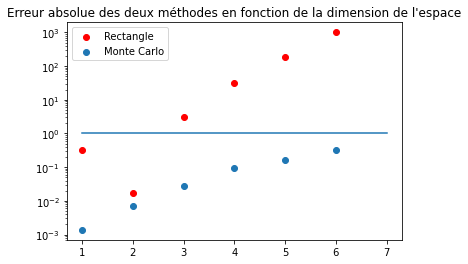

In [ ]:
#Représentation graphique
D = 7
T_max = 0.1
N = 10 #nombre d'échantillons pour la Monte Carlo

X = []
Y_rect = []
Y_MC = []

for i in range(1,D):
  X.append(i)
  Y_rect.append(erreur(methode_rectangle_d,T_max,i))
  
  Y_MC_echantillon = np.empty(N)
  for j in range(N):
    Y_MC_echantillon[j] = erreur(MC,T_max,i)
  
  Y_MC.append(np.mean(Y_MC_echantillon))


scatter(X,Y_rect,c="red")
scatter(X,Y_MC)
legend(["Rectangle","Monte Carlo"])
plot([1,D],[1,1])
title("Erreur absolue des deux méthodes en fonction de la dimension de l'espace")
yscale("log")


Le théorème d'invariance de l'erreur en fonction du nombre de points pour Monte Carlo (vu dans la sous-partie précédente) n'est pas incohérent avec ce qu'on trouve ici.

En effet, le temps d'exécution de l'algorithme de Monte Carlo est  tout de même aussi influé par la dimension : un point en dimension d est plus couteux, car il a besoin de d coordonnées pour être défini. (Cf l'algorithme : on a une boucle for parcourue d fois pour déterminer les n points.)

**Conclusion finale**

  Nous constatons que les deux méthodes ont des erreurs absolues croissantes de la dimension de l'espace.

Cependant; leur rythme de croissance est différent. Pour la méthode des rectangles, à partir de de la dimension 3, l'erreur croît de manière exponentielle, tandis que l'erreur de la méthode de Monte Carlo croît de manière plus faible que d'une manière exponentielle.

C'est une illustration du *fléau de la dimension*, les méthodes numériques usuelles ont des complexités exponentielles de la dimension.  

  
    

  En bref, pour une erreur absolue fixée:
* Monte Carlo nécessite un nombre de points $n$ constant, mais dont la définition nécessite plus de temps avec la dimension (car un point y est défini par ses d coordonnées.)
* la méthode des rectangles a besoin d'un plus grand nombres de points n (fléau de la dimension) et comme Monte Carlo, subit une augmentation du temps de définition de ses points.


In [ ]:
def f_naive(x,y):
  return x*y

def f(X):
  return X[0]*X[1]

# Démonstration d'une fonction pour la soutenance

In [ ]:
def fonc_soutenance(x):
  return x

print(MC(fonc_soutenance,support_d(1),10**5))

[0.00929302]


(array([ 968., 1003., 1037.,  981., 1034.,  959.,  997., 1030., 1004.,
         987.]),
 array([1.45690780e-04, 1.00125835e-01, 2.00105979e-01, 3.00086123e-01,
        4.00066267e-01, 5.00046411e-01, 6.00026555e-01, 7.00006699e-01,
        7.99986844e-01, 8.99966988e-01, 9.99947132e-01]),
 <a list of 10 Patch objects>)

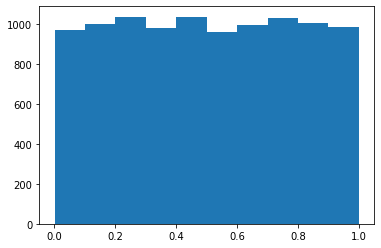

In [ ]:
L = []

for i in range(10**4):
  
  Z = 0
  for j in range(1,10**3):
    B =  1*(rand()<0.5)
    Z+= B/2**j
  
  L.append(Z)

hist(L)
